# **Vehicle Detection and Tracking** 
***
The goals / steps of this project are the following:

    1.Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
    2. Apply a distortion correction to raw images.
    3. Use color transforms, gradients, etc., to create a thresholded binary image.
    4. Apply a perspective transform to rectify binary image ("birds-eye view").
    5. Detect lane pixels and fit to find the lane boundary.
    6. Determine the curvature of the lane and vehicle position with respect to center.
    7. Warp the detected lane boundaries back onto the original image.
    8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob
import cv2
import pickle
import glob
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
import time
from skimage.feature import hog
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
%matplotlib inline
#%matplotlib qt



**Manual Dectection**

Use 20 sample chess board picutures under /camera_cal directory to calibrate camera. 

First step, load camlibration image, create object point and image point arrary and use cv2.findChessboardCorner cv2.drawChessboardCorners functiuon to find and draw chessborad coners

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

In [2]:
#Test image forlder
test_dir = "test_images/"
# 
dataset_dir = "dataset/"

**Template Matching**

Ues object points and image points collected in part 1 as input to cv2.calibrateCamer to get camera calibration matrix and disort distance. And use one of the image to test it.  Finally save camera calibrate matrix in a file so that it can be loaded from file later



**Histogram of Color **




In [3]:

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features




**Spatial Binning of Color**

Convert color space into feature vector which can be used in classifier training


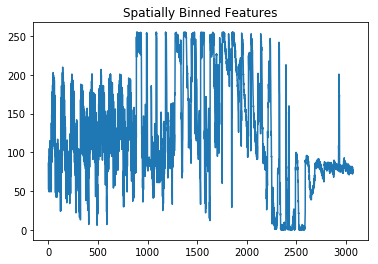

In [3]:

# Define a function to compute color histogram features  
# Pass the color_space flag as 3-letter all caps string
# like 'HSV' or 'LUV' etc.
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features

image =  mpimg.imread(test_dir +'cutout1.jpg')
feature_vec = bin_spatial(image, color_space='RGB', size=(32, 32))

# Plot features
plt.plot(feature_vec)
plt.title('Spatially Binned Features')
plt.show()

## Build Data Dictionary

Collect sample images and put into a dictionary


Path name:  dataset/vehicles/*/*.png
Total car image number:  8792
Smaple image name:  dataset/vehicles/GTI_MiddleClose/image0206.png
Num of cars:  8792
Num of noncars:  8792
Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


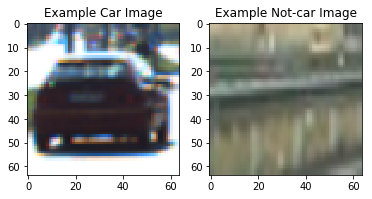

In [4]:
#from skimage.feature import hog
#from skimage import color, exposure
# images are divided up into vehicles and non-vehicles
cars_path_name = dataset_dir + 'vehicles/' + '*/*.png'
notcars_path_name = dataset_dir + 'non-vehicles/' + '*/*.png'
print('Path name: ', cars_path_name)


cars = glob.glob(cars_path_name)
notcars = glob.glob(notcars_path_name)
print('Total car image number: ', len(cars))
print('Smaple image name: ', cars[0])
        
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}    
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    print('Num of cars: ', data_dict["n_cars"])
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    print('Num of noncars: ', data_dict["n_cars"])
    # Read in a test image, either car or notcar
    test_image = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = test_image.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = test_image.dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')

# Ski-Image HOG

Collect sample images and put into a dictionary

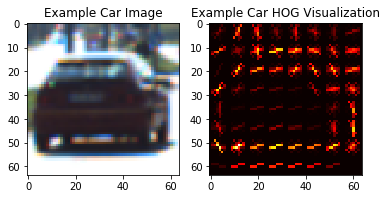

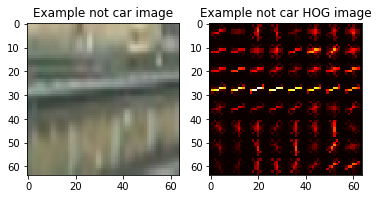

In [10]:
# Define a function to return HOG features and visualization, the input image should be a single channel image
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    
    
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image =hog(img,
                             orientations=orient, 
                             pixels_per_cell=(pix_per_cell, pix_per_cell), 
                             cells_per_block=(cell_per_block, cell_per_block), 
                             visualise=vis, 
                             feature_vector=feature_vec)
       
        return features, hog_image
    else:      
        # Use skimage.hog() to get features only
        features =hog(img,
                             orientations=orient, 
                             pixels_per_cell=(pix_per_cell, pix_per_cell), 
                             cells_per_block=(cell_per_block, cell_per_block), 
                             visualise=vis, 
                             feature_vector=feature_vec)
        return features

pix_per_cell = 8
cell_per_block = 2
orient = 9
car_gray = cv2.cvtColor(car_image, cv2.COLOR_RGB2GRAY)
notcar_gray = cv2.cvtColor(notcar_image, cv2.COLOR_RGB2GRAY)
# Call our function with vis=True to see an image output
car_features, car_hog_image = get_hog_features(car_gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
notcar_features, notcar_hog_image = get_hog_features(notcar_gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)





# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(car_hog_image, cmap = 'hot')
plt.title('Example Car HOG Visualization')
plt.show()
fig = plt.figure()
plt.subplot(121)
plt.imshow(notcar_image)
plt.title('Example not car image')
plt.subplot(122)
plt.imshow(notcar_hog_image, cmap = 'hot')
plt.title('Example not car HOG image')
plt.show()



## Sliding Window Implementation

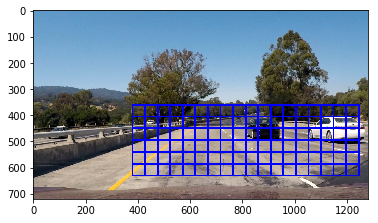

In [11]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

image = mpimg.imread(test_dir + 'test1.jpg')
y_offset = 60
x_offset = 60
x_start = image.shape[1]//4 + x_offset
y_start = image.shape[0]//2
y_stop = image.shape[0] - y_offset 
windows = slide_window(image, x_start_stop=[x_start, None], y_start_stop=[y_start, y_stop], 
                    xy_window=(96, 90), xy_overlap=(0.5, 0.5))
                       
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

## Search and Classify

In [12]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        # Resacale back between 0 and 1
        feature_image = feature_image.astype(np.float32)/255.0    
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [13]:


### TODO: Tweak these parameters and see how the results change.
color_space = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

car_features =[]
notcar_features = []


for file in cars:
    # Read in each one by one
    image = mpimg.imread(file)
    img_features = single_img_features(image, color_space=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=hog_channel,
                        spatial_feat=True, hist_feat=True, hog_feat=True)
    car_features.append(img_features)
    
for file in notcars:
    # Read in each one by one
    image = mpimg.imread(file)
    img_features = single_img_features(image, color_space=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=hog_channel,
                        spatial_feat=True, hist_feat=True, hog_feat=True)
    notcar_features.append(img_features)   



print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')

X = np.vstack((car_features, notcar_features)).astype(np.float64) 

print('Image feature vector length:', len(X[0]))
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

DATASET_FILE = "p5_dataset_LUV.pkl"

dist_pickle = {}
dist_pickle["X_train"] = scaled_X 
dist_pickle["y_label"] = y
pickle.dump( dist_pickle, open( DATASET_FILE, "wb" ) )

print('Extracted Dataset saved')





Using: 9 orientations 8 pixels per cell and 2 cells per block
Image feature vector length: 8460
Extracted Dataset saved


## Test different Classfier

In [14]:
#Load camera saved calibration matrix and from pickle file
with open(DATASET_FILE, mode='rb') as f:
    loaded_dataset = pickle.load(f)
    
X, y = loaded_dataset["X_train"], loaded_dataset["y_label"]

print('Dataset Loaded. Total data size: ', len(X) )

rand_state = np.random.randint(0, 100)
X, y = shuffle(X, y, random_state=rand_state)


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)


print('Feature vector length:', len(X_train[0]))


Dataset Loaded. Total data size:  17760
Feature vector length: 8460


In [16]:
PERF_FORMAT_STRING = "\
\tAccuracy: {:>0.{display_precision}f}\tPrecision: {:>0.{display_precision}f}\t\
Recall: {:>0.{display_precision}f}\tF1: {:>0.{display_precision}f}\tF2: {:>0.{display_precision}f}"
RESULTS_FORMAT_STRING = "\tTotal predictions: {:4d}\nTrue positives: {:4d}\tFalse positives: {:4d}\nFalse negatives: {:4d}\tTrue negatives: {:4d}"


def test_classifier(clf, X_train, X_test, y_train, y_test):
    # Check the training time for the SVC
    t=time.time()
    clf.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train Classifier...')
    predictions = clf.predict(X_test)
    true_negatives = 0
    false_negatives = 0
    true_positives = 0
    false_positives = 0
    for prediction, truth in zip(predictions, y_test):        
        if prediction == 0 and truth == 0:
            true_negatives += 1
        elif prediction == 0 and truth == 1:
            false_negatives += 1
        elif prediction == 1 and truth == 0:
            false_positives += 1
        else:
            true_positives += 1

    accuracy, precision,  recall, f1, f2 =0, 0, 0, 0 ,0
    try:
        total_predictions = true_negatives + false_negatives + false_positives + true_positives
        accuracy = 1.0*(true_positives + true_negatives)/total_predictions
        precision = 1.0*true_positives/(true_positives+false_positives)
        recall = 1.0*true_positives/(true_positives+false_negatives)
        f1 = 2.0 * true_positives/(2*true_positives + false_positives+false_negatives)
        f2 = (1+2.0*2.0) * precision*recall/(4*precision + recall)
        print (clf)
        print (PERF_FORMAT_STRING.format(accuracy, precision, recall, f1, f2, display_precision = 5))
        print (RESULTS_FORMAT_STRING.format(total_predictions, true_positives, false_positives, false_negatives, true_negatives))
        print ("")
    except:
        print( "Got a divide by zero when trying out:", clf)
        
    return  accuracy, precision,  recall, f1, f2
            
            
dict_clfs = {}
CLASSIFIER_FILE = 'p5_Classifiers_LUV.pkl'
    
# Use a linear SVC 
print('Test Linear SVC...')
svc = LinearSVC()
test_classifier(svc, X_train, X_test, y_train, y_test)
dict_clfs["SVC"] = svc

##SVM
#from sklearn.svm import SVC
#print('Test SVM...')
#svm = SVC(C=10, cache_size=200, class_weight='balanced',
#    coef0=0.0, degree=3, gamma=0.1, kernel='rbf'  )       
#test_classifier(svm, X_train, X_test, y_train, y_test)
#dict_clfs["SVM"] = svm
    
##Decision Tree     
#from sklearn import tree
#print('Test Decision Tree...')
#dt = tree.DecisionTreeClassifier(min_samples_split=20)     
#test_classifier(dt, X_train, X_test, y_train, y_test)
#dict_clfs["DT"] = dt
      
    
##K Nearest Neighbors
#from sklearn.neighbors import KNeighborsClassifier 
#print('Test K Nearest Neighbors...')
#knn = KNeighborsClassifier(n_neighbors=10, weights = 'distance' )
#test_classifier(knn, X_train, X_test, y_train, y_test)    
#dict_clfs["KNN"] = knn

##Random Forest
from sklearn.ensemble import RandomForestClassifier
print('Test Random Forest...')
rf = RandomForestClassifier(n_estimators=200,  random_state=43)
test_classifier(rf, X_train, X_test, y_train, y_test)
dict_clfs["RF"] = rf 
    
## Ada Boost
from sklearn.ensemble import AdaBoostClassifier
print('Test Ada Boost...')
adb = AdaBoostClassifier(n_estimators=50, random_state = 37)
test_classifier(adb, X_train, X_test, y_train, y_test)
dict_clfs["adb"] = adb  
    
pickle.dump( dist_pickle, open( CLASSIFIER_FILE, "wb" ) )


Test Linear SVC...
19.34 Seconds to train Classifier...
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
	Accuracy: 0.98818	Precision: 0.99234	Recall: 0.98308	F1: 0.98769	F2: 0.98492
	Total predictions: 3552
True positives: 1685	False positives:   13
False negatives:   29	True negatives: 1825

Test Random Forest...
59.34 Seconds to train Classifier...
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=43,
            verbose=0, warm_start=False)
	Accuracy: 0.97804	Precision: 0.97836	Recall: 0.97608	F1: 0.97722	F2: 0.97654
	Total predictions: 3

In [30]:
dict_clfs = {}
CLASSIFIER_FILE = 'p5_Classifiers_LUV_2'

# Use a linear SVC 
print('Test Linear SVC...')
svc = LinearSVC()
test_classifier(svc, X_train, X_test, y_train, y_test)
dict_clfs["SVC"] = svc

##Random Forest
from sklearn.ensemble import RandomForestClassifier
print('Test Random Forest...')
rf = RandomForestClassifier(n_estimators=200,  random_state=43)
test_classifier(rf, X_train, X_test, y_train, y_test)
dict_clfs["RF"] = rf 
    
## Ada Boost
from sklearn.ensemble import AdaBoostClassifier
print('Test Ada Boost...')
adb = AdaBoostClassifier(n_estimators=100, random_state = 37)
test_classifier(adb, X_train, X_test, y_train, y_test)
dict_clfs["adb"] = adb  
    
pickle.dump( dist_pickle, open( CLASSIFIER_FILE, "wb" ) )

Test Linear SVC...
7.81 Seconds to train Classifier...
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
	Accuracy: 0.98818	Precision: 0.99234	Recall: 0.98308	F1: 0.98769	F2: 0.98492
	Total predictions: 3552
True positives: 1685	False positives:   13
False negatives:   29	True negatives: 1825

Test Random Forest...
236.06 Seconds to train Classifier...
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=1, oob_score=False, random_state=43,
            verbose=0, warm_start=False)
	Accuracy: 0.98114	Precision: 0.98017	Recall: 0.98075	F1: 0.98046	F2: 0.98063
	Total predictions: 

In [29]:


def get_hot_windows(image, clf, X_scaler, 
                    x_start_stop=[None, None], 
                    y_start_stop=[None, None], 
                    xy_windows=[(96, 96)], 
                    xy_overlap=(0.5, 0.5),  
                    color_space=("RGB"), 
                    spatial_size=32, hist_bins=32, 
                    orient=9, pix_per_cell=8, 
                    cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):
    hot_windows = []
    for xy_window in xy_windows:
        windows = slide_window(image, x_start_stop= x_start_stop, 
                               y_start_stop=y_start_stop, 
                               xy_window=xy_window, 
                               xy_overlap=(0.5, 0.5))
        hot_windows.extend( search_windows(image, windows, clf, X_scaler, 
                                           color_space=color_space, 
                                           spatial_size=spatial_size,
                                           hist_bins=hist_bins, 
                                           orient=orient, 
                                           pix_per_cell=pix_per_cell, 
                                           cell_per_block=cell_per_block, 
                                           hog_channel=hog_channel, 
                                           spatial_feat=spatial_feat, 
                                           hist_feat=hist_feat, hog_feat=hog_feat
                                          )
                          )
    return hot_windows    



    




In [ ]:
import os    
test_folder = "test_images"
test_images = os.listdir(test_folder)
xy_windows = [(48, 48), (96, 96), (128, 128), (192, 192)]
xy_overlap = (0.5, 0.5)
y_offset = 20
x_start = image.shape[1]//4
y_start = image.shape[0]//2
y_stop = image.shape[0] - y_offset 
x_start_stop=[x_start, None]
y_start_stop=[y_start, y_stop]

for test_image in test_images:
    print('file name:',  test_image) 
    if  not('test' in test_image):
        continue
    test_image_file = os.path.join(test_folder, test_image)    
    image = mpimg.imread(test_image_file)
    draw_image = np.copy(image)
    showColorImage(image, 'Original')
    image = image.astype(np.float32)/255.0 #Scale to (0, 1)
    for clf_name in dict_clfs.keys():
        print('Using classifier: ', clf_name)
        clf = dict_clfs[clf_name]
        input_image = np.copy(image)
        hot_windows = get_hot_windows(input_image, clf, X_scaler, 
                                      x_start_stop=x_start_stop, 
                                      y_start_stop=y_start_stop, 
                                      xy_windows=xy_windows, 
                                      xy_overlap=xy_overlap, 
                                      color_space=color_space, 
                                      spatial_size=spatial_size, 
                                      hist_bins=hist_bins, 
                                      orient=orient, 
                                      pix_per_cell=pix_per_cell, 
                                      cell_per_block=cell_per_block, 
                                      hog_channel=hog_channel, 
                                      spatial_feat=spatial_feat, 
                                      hist_feat=hist_feat, 
                                      hog_feat=hog_feat
                                     )
        window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6) 
        showColorImage(window_img, 'Widowns marked')
   


**Try different sliding window size**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [ ]:
import os    
test_folder = "test_images"
test_images = os.listdir(test_folder)
xy_windows = [(32, 32), (64, 64), (96, 96), (128, 128)]
xy_overlap = (0.5, 0.5)
y_offset = 60
x_start = image.shape[1]//4
y_start = image.shape[0]//2
y_stop = image.shape[0] - y_offset 
x_start_stop=[x_start, None]
y_start_stop=[y_start, y_stop]

for test_image in test_images:
    print('file name:',  test_image) 
    if  not('test' in test_image):
        continue
    test_image_file = os.path.join(test_folder, test_image)    
    image = mpimg.imread(test_image_file)
    draw_image = np.copy(image)
    showColorImage(image, 'Original')
    image = image.astype(np.float32)/255.0 #Scale to (0, 1)
    for clf_name in dict_clfs.keys():
        print('Using classifier: ', clf_name)
        clf = dict_clfs[clf_name]
        input_image = np.copy(image)
        hot_windows = get_hot_windows(input_image, clf, X_scaler, 
                                      x_start_stop=x_start_stop, 
                                      y_start_stop=y_start_stop, 
                                      xy_windows=xy_windows, 
                                      xy_overlap=xy_overlap, 
                                      color_space=color_space, 
                                      spatial_size=spatial_size, 
                                      hist_bins=hist_bins, 
                                      orient=orient, 
                                      pix_per_cell=pix_per_cell, 
                                      cell_per_block=cell_per_block, 
                                      hog_channel=hog_channel, 
                                      spatial_feat=spatial_feat, 
                                      hist_feat=hist_feat, 
                                      hog_feat=hog_feat
                                     )
        window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6) 
        showColorImage(window_img, 'Widowns marked')
   

## Heat Map

Original


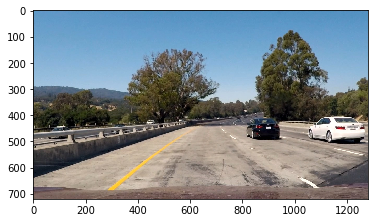

Widowns marked


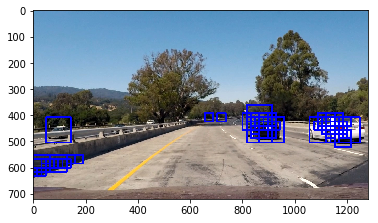

heat map


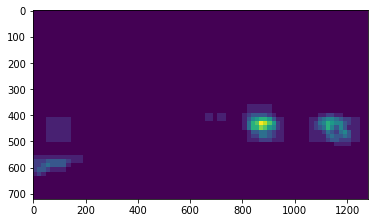

Threshold heat map


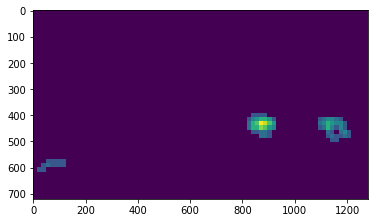

In [25]:
# Read in the last image shown above 
def showColorImage(img, title):
    print (title)
    plt.imshow(img)
    plt.show()  



def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    
    # Return updated heatmap
    return heatmap
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

    
# Read in the last image above
image = mpimg.imread(test_dir + 'test1.jpg')
heat = np.zeros_like(image[:,:,0]).astype(np.float)
draw_image = np.copy(image)
showColorImage(image, 'Original')
image = image.astype(np.float32)/255.0 #Scale to (0, 1)
input_image = np.copy(image)
hot_windows = get_hot_windows(input_image, rf, X_scaler, 
                                      x_start_stop=x_start_stop, 
                                      y_start_stop=y_start_stop, 
                                      xy_windows=xy_windows, 
                                      xy_overlap=xy_overlap, 
                                      color_space=color_space, 
                                      spatial_size=spatial_size, 
                                      hist_bins=hist_bins, 
                                      orient=orient, 
                                      pix_per_cell=pix_per_cell, 
                                      cell_per_block=cell_per_block, 
                                      hog_channel=hog_channel, 
                                      spatial_feat=spatial_feat, 
                                      hist_feat=hist_feat, 
                                      hog_feat=hog_feat
                                     )
window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6) 
showColorImage(window_img, 'Widowns marked')
heatmap = add_heat(heat, hot_windows)
showColorImage(heatmap, 'heat map')
final_heat_map = apply_threshold(heatmap, 2)
showColorImage(final_heat_map, 'Threshold heat map')



3 cars found


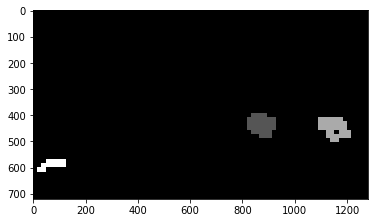

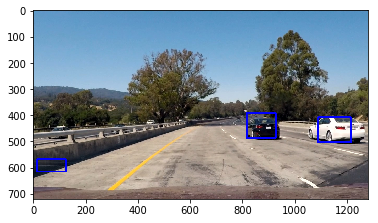

In [26]:
from scipy.ndimage.measurements import label
labels = label(final_heat_map)
print(labels[1], 'cars found')
plt.imshow(labels[0], cmap='gray')
plt.show()

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Draw bounding boxes on a copy of the image
draw_img = draw_labeled_bboxes(draw_image, labels)
# Display the image
plt.imshow(draw_img)    
    




file name: test5.jpg
Original


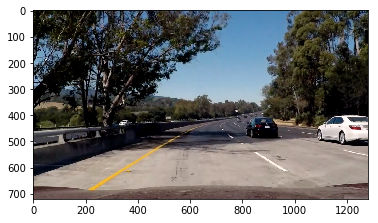

Using classifier:  adb
Widowns marked


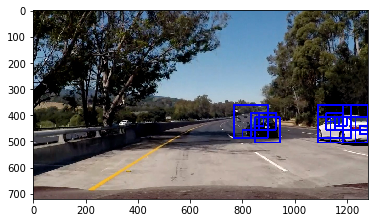

heat map


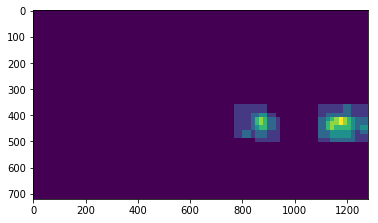

Threshold heat map


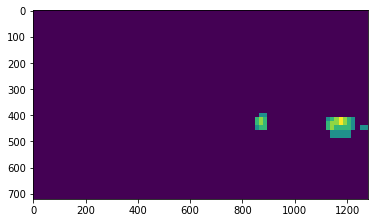

3 cars found
Heat Map


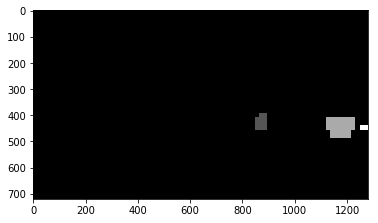

Final Result


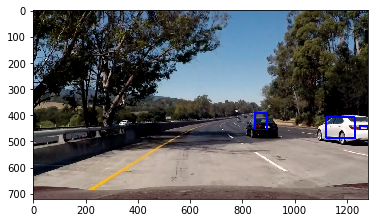

Using classifier:  RF
Widowns marked


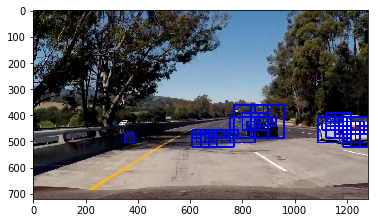

heat map


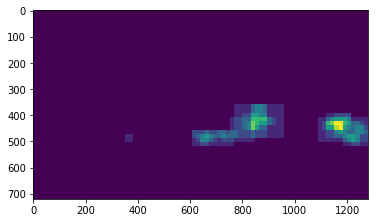

Threshold heat map


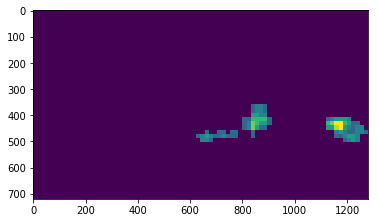

3 cars found
Heat Map


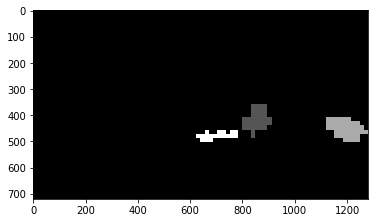

Final Result


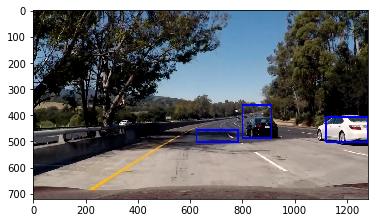

Using classifier:  SVC
Widowns marked


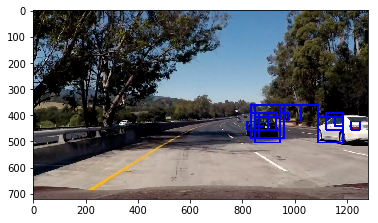

heat map


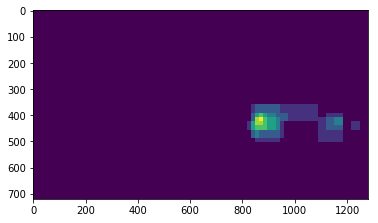

Threshold heat map


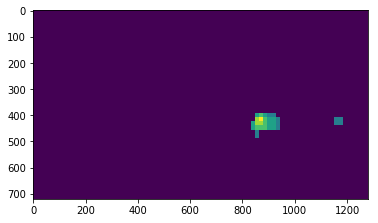

2 cars found
Heat Map


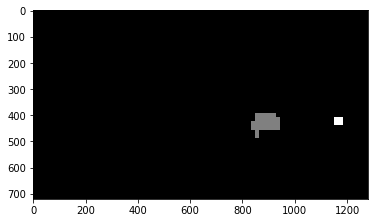

Final Result


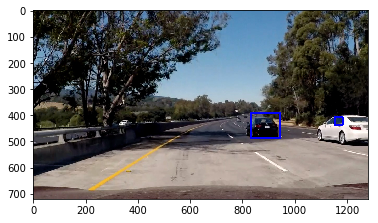

file name: .DS_Store
file name: test6.jpg
Original


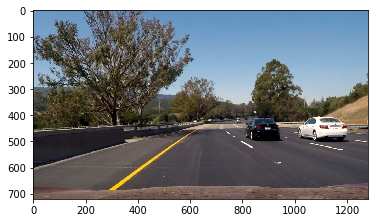

Using classifier:  adb
Widowns marked


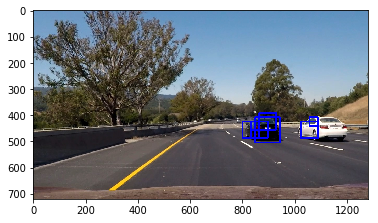

heat map


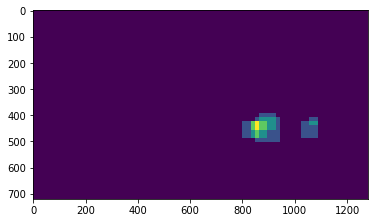

Threshold heat map


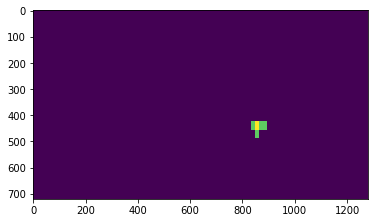

1 cars found
Heat Map


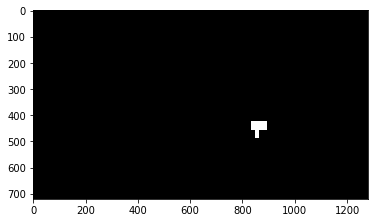

Final Result


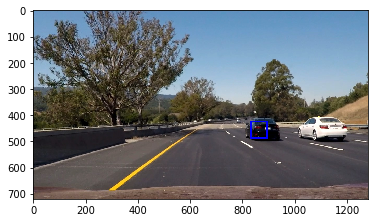

Using classifier:  RF
Widowns marked


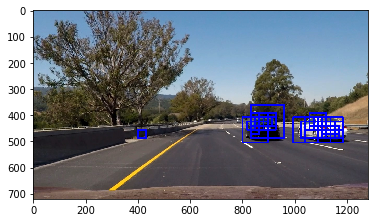

heat map


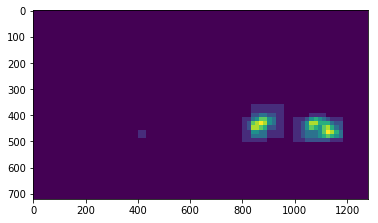

Threshold heat map


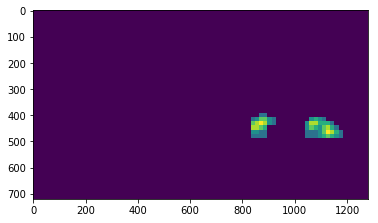

2 cars found
Heat Map


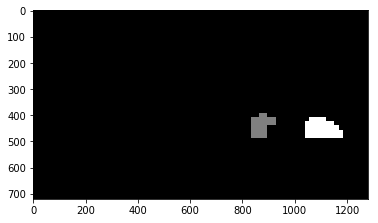

Final Result


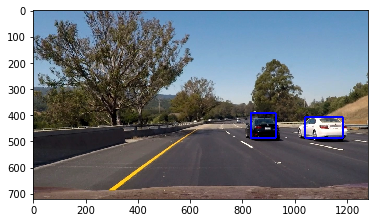

Using classifier:  SVC
Widowns marked


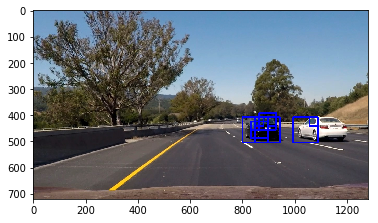

heat map


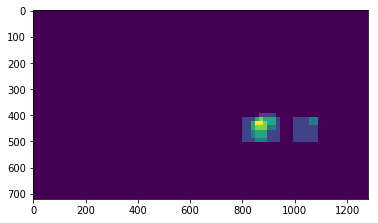

Threshold heat map


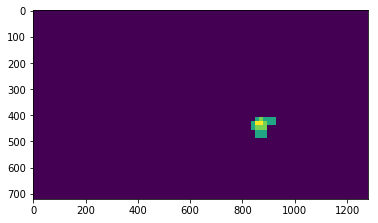

1 cars found
Heat Map


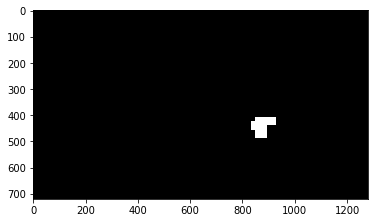

Final Result


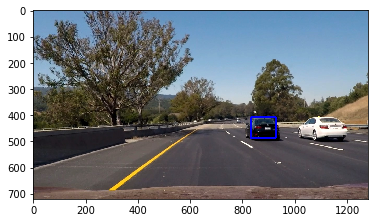

file name: cutout1.jpg
file name: test4.jpg
Original


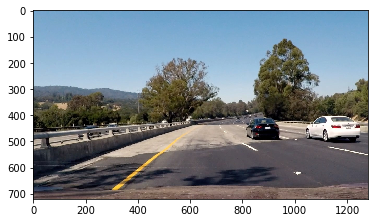

Using classifier:  adb
Widowns marked


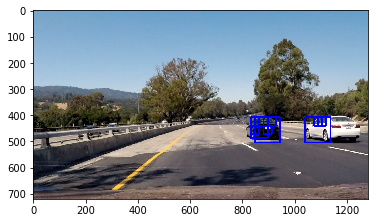

heat map


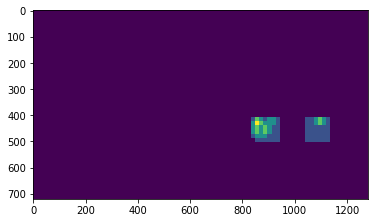

Threshold heat map


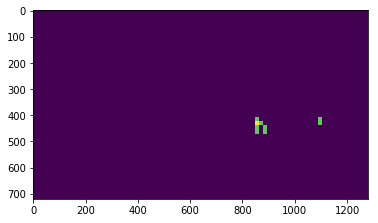

3 cars found
Heat Map


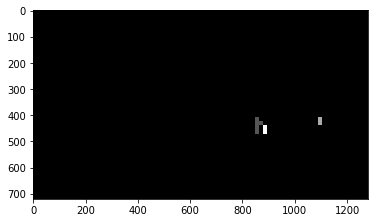

Final Result


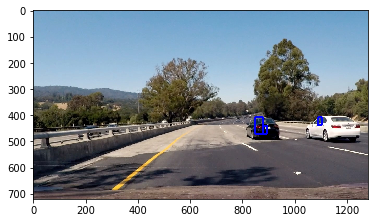

Using classifier:  RF
Widowns marked


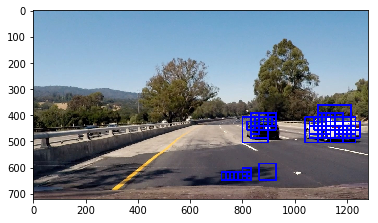

heat map


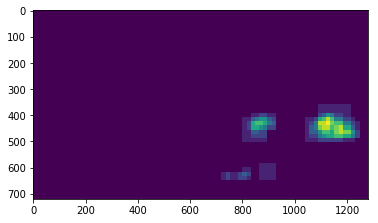

Threshold heat map


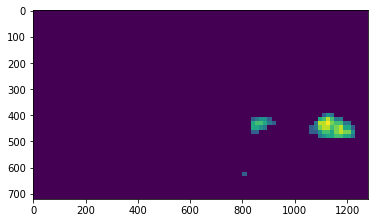

3 cars found
Heat Map


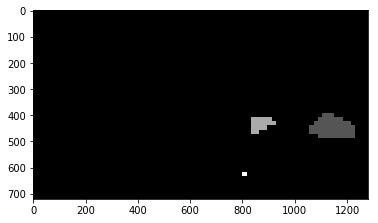

Final Result


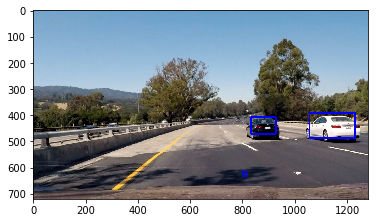

Using classifier:  SVC
Widowns marked


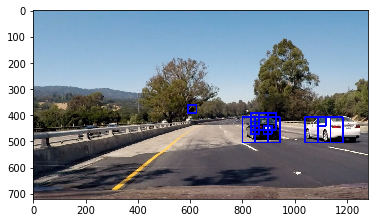

heat map


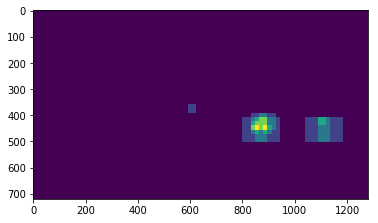

Threshold heat map


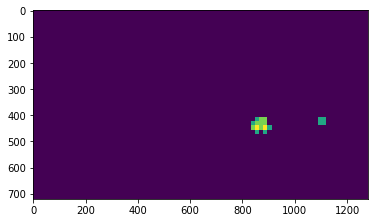

2 cars found
Heat Map


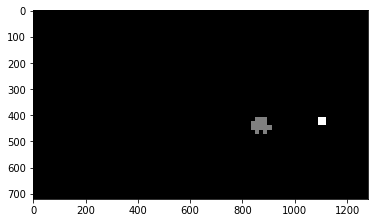

Final Result


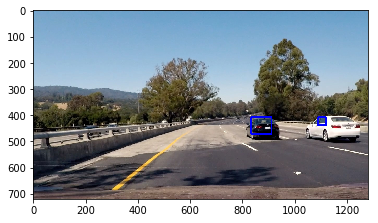

file name: test1.jpg
Original


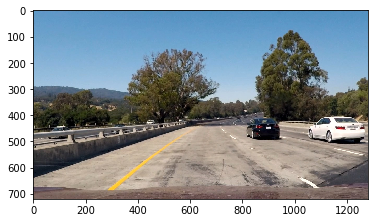

Using classifier:  adb
Widowns marked


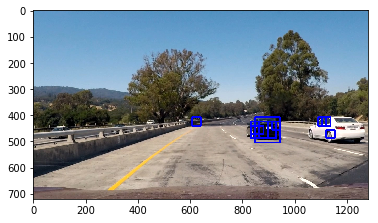

heat map


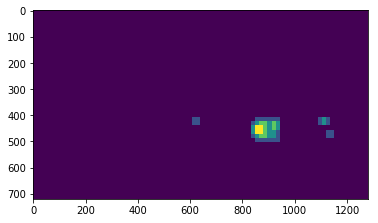

Threshold heat map


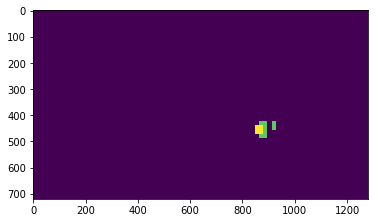

2 cars found
Heat Map


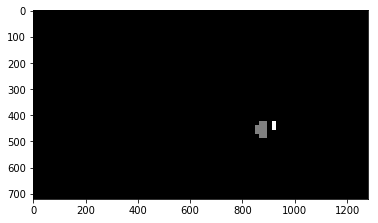

Final Result


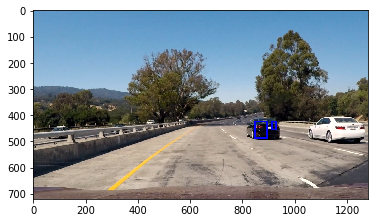

Using classifier:  RF
Widowns marked


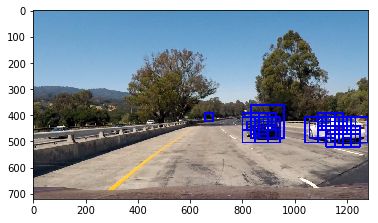

heat map


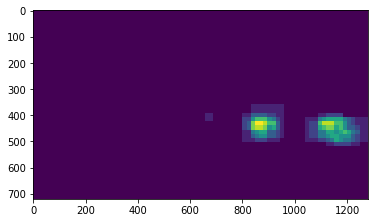

Threshold heat map


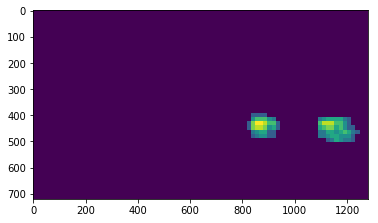

2 cars found
Heat Map


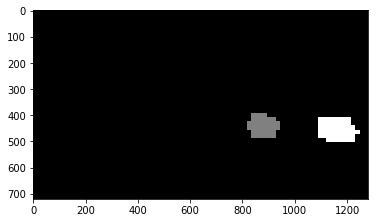

Final Result


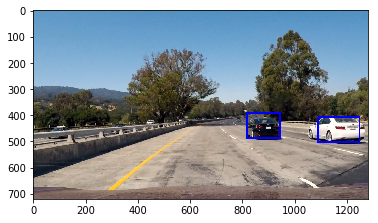

Using classifier:  SVC
Widowns marked


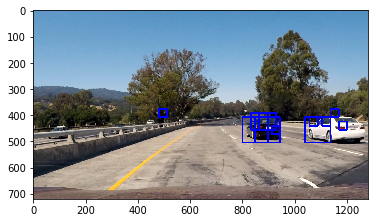

heat map


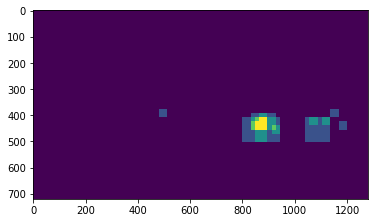

Threshold heat map


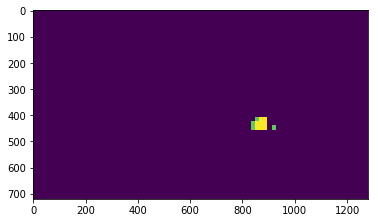

2 cars found
Heat Map


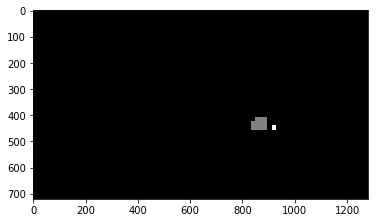

Final Result


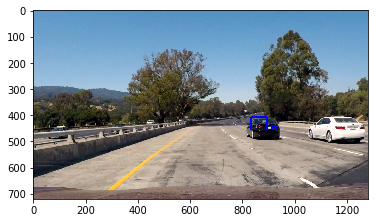

file name: test3.jpg
Original


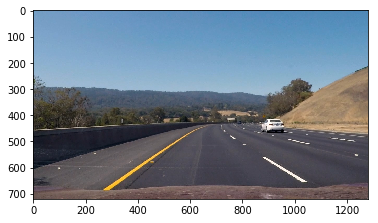

Using classifier:  adb
Widowns marked


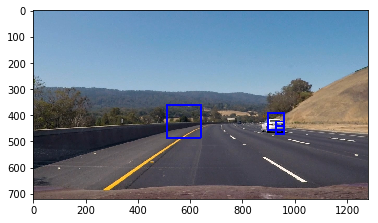

heat map


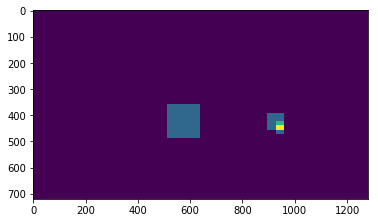

Threshold heat map


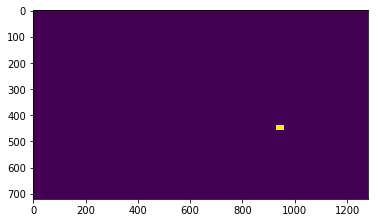

1 cars found
Heat Map


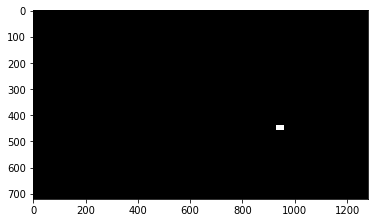

Final Result


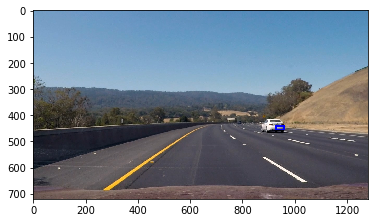

Using classifier:  RF
Widowns marked


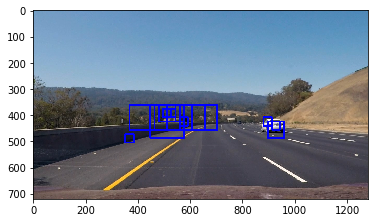

heat map


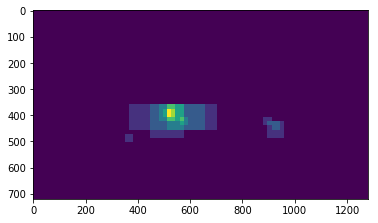

Threshold heat map


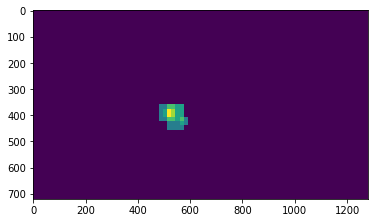

1 cars found
Heat Map


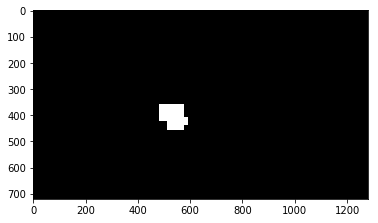

Final Result


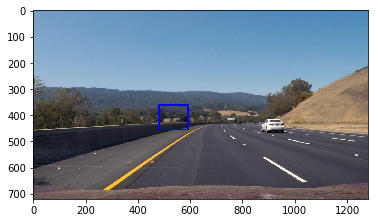

Using classifier:  SVC
Widowns marked


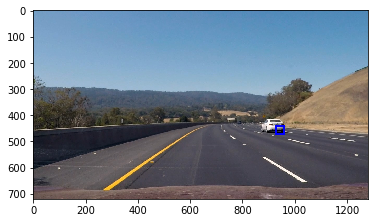

heat map


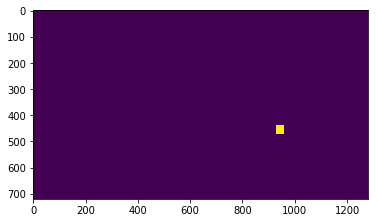

Threshold heat map


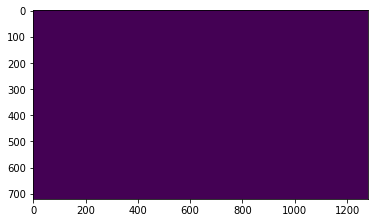

0 cars found
Heat Map


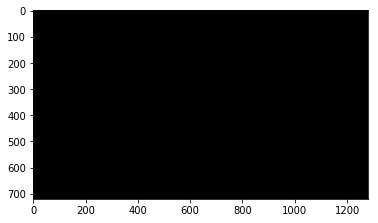

Final Result


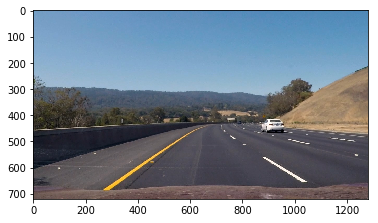

file name: test2.jpg
Original


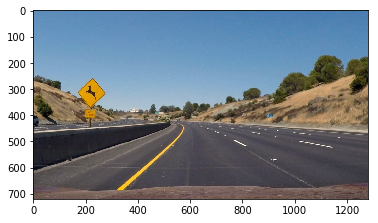

Using classifier:  adb
Widowns marked


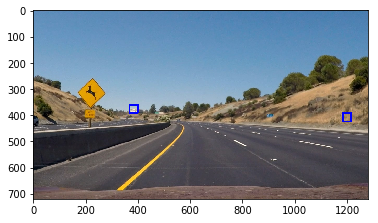

heat map


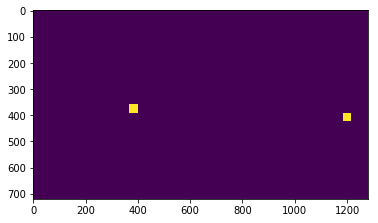

Threshold heat map


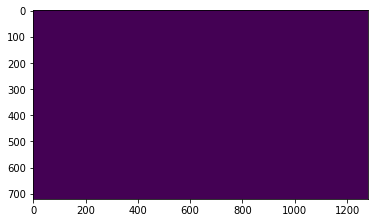

0 cars found
Heat Map


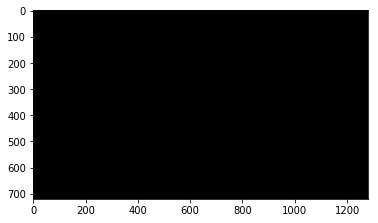

Final Result


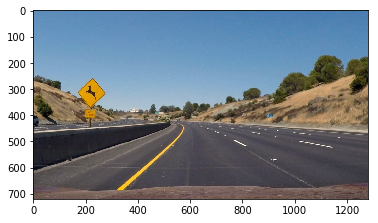

Using classifier:  RF
Widowns marked


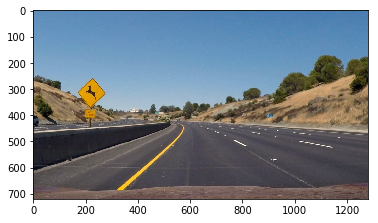

heat map


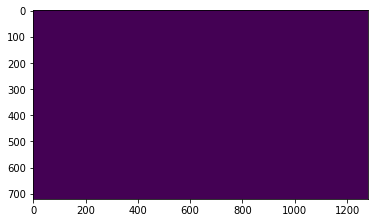

Threshold heat map


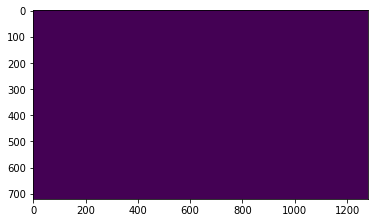

0 cars found
Heat Map


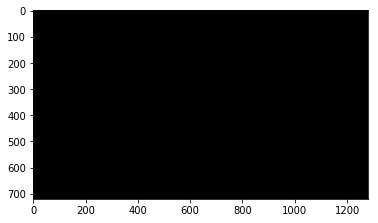

Final Result


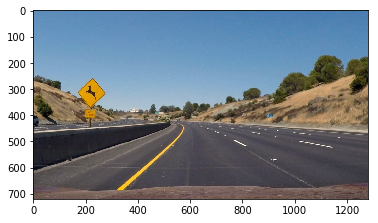

Using classifier:  SVC
Widowns marked


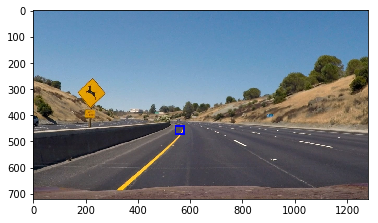

heat map


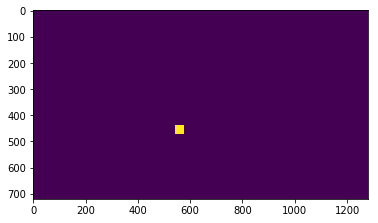

Threshold heat map


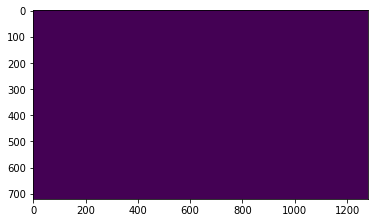

0 cars found
Heat Map


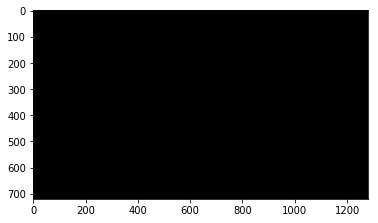

Final Result


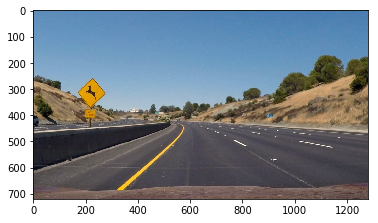

In [32]:
def showGrayImage(img, title):
    print (title)
    plt.imshow(img, cmap='gray')
    plt.show()
    
def pipeline(image, clf, X_scaler, 
                    x_start_stop=[None, None], 
                    y_start_stop=[None, None], 
                    xy_windows=[(96, 96)], 
                    xy_overlap=(0.5, 0.5),  
                    color_space=("RGB"), 
                    spatial_size=32, hist_bins=32, 
                    orient=9, pix_per_cell=8, 
                    cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):
    
    hot_windows = get_hot_windows(input_image, clf, X_scaler, 
                                      x_start_stop=x_start_stop, 
                                      y_start_stop=y_start_stop, 
                                      xy_windows=xy_windows, 
                                      xy_overlap=xy_overlap, 
                                      color_space=color_space, 
                                      spatial_size=spatial_size, 
                                      hist_bins=hist_bins, 
                                      orient=orient, 
                                      pix_per_cell=pix_per_cell, 
                                      cell_per_block=cell_per_block, 
                                      hog_channel=hog_channel, 
                                      spatial_feat=spatial_feat, 
                                      hist_feat=hist_feat, 
                                      hog_feat=hog_feat
                                     )
    


import os    
test_folder = "test_images"
test_images = os.listdir(test_folder)
xy_windows = [(32, 32), (64, 64), (96, 96), (128, 128)]
xy_overlap = (0.5, 0.5)
y_offset = 60
x_start = image.shape[1]//4
y_start = image.shape[0]//2
y_stop = image.shape[0] - y_offset 
x_start_stop=[x_start, None]
y_start_stop=[y_start, y_stop]

for test_image in test_images:
    print('file name:',  test_image) 
    if  not('test' in test_image):
        continue
    test_image_file = os.path.join(test_folder, test_image)    
    image = mpimg.imread(test_image_file)
    draw_image = np.copy(image)    
    showColorImage(image, 'Original')
    image = image.astype(np.float32)/255.0 #Scale to (0, 1)    
    for clf_name in dict_clfs.keys():
        print('Using classifier: ', clf_name)
        clf = dict_clfs[clf_name]
        draw_image_2 =  np.copy(draw_image)
        draw_image_3 =  np.copy(draw_image)
        input_image = np.copy(image)
        heat_2 = np.zeros_like(input_image[:,:,0]).astype(np.float)
        hot_windows = get_hot_windows(input_image, clf, X_scaler, 
                                      x_start_stop=x_start_stop, 
                                      y_start_stop=y_start_stop, 
                                      xy_windows=xy_windows, 
                                      xy_overlap=xy_overlap, 
                                      color_space=color_space, 
                                      spatial_size=spatial_size, 
                                      hist_bins=hist_bins, 
                                      orient=orient, 
                                      pix_per_cell=pix_per_cell, 
                                      cell_per_block=cell_per_block, 
                                      hog_channel=hog_channel, 
                                      spatial_feat=spatial_feat, 
                                      hist_feat=hist_feat, 
                                      hog_feat=hog_feat
                                     )
        window_img = draw_boxes(draw_image_2, hot_windows, color=(0, 0, 255), thick=6) 
        showColorImage(window_img, 'Widowns marked')        
        heatmap_2 = add_heat(heat_2 , hot_windows)
        showColorImage(heatmap_2, 'heat map')
        final_heat_map_2 = apply_threshold(heatmap_2, 2)
        showColorImage(final_heat_map_2, 'Threshold heat map')
        labels_2 = label(final_heat_map_2)
        print(labels_2[1], 'cars found')
        showGrayImage(labels_2[0], 'Heat Map')        
        # Draw bounding boxes on a copy of the image
        final_img_2 = draw_labeled_bboxes(draw_image_3, labels_2)
        # Display the image
        showColorImage(final_img_2, 'Final Result')
        hot_windows = [] #reset hot windows
        

## Reflections

Here are some challenges that I had in this project:

    Perspective transformation. I spent a lot of time trying to find good source and destination points to transform image to bird-eye view. I tested lots of combination. The source and destination points that I used work ok for this project but I don't think they are very good. I am wondering whether there is a good way to find proper source and destination sets.

    I found my pipeline doesn't work too well on bright area even if I used HSL color space. Maybe, my threshold can be improved. And combination of different binary image can make the pipeline more robust.

    I used simple average method to get average fit of last 5 good frames. It works OK in project video but I am not sure if it is the right way to do it.

